In [1]:
#pstat.py
#Project Data Analysis Notebook
#by Daniel H

In [2]:
#Imports
import pandas as pd
import numpy as np
from datetime import datetime
import scipy.stats as stats
from collections import defaultdict
import itertools

import os
import requests
import urllib
import json

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from evaluate import load

In [3]:
#P1 Affiliates List
p1_master = pd.read_excel('RandomPeople.xlsx')
p1_master.dropna(axis=1, how='all')

,First Name(s),Last Name,Orcid,Primary,Other,Secondary
0,Oke,Gerke,https://orcid.org/0000-0001-6335-3303,Learning Theory & Optimization (LO),NaN,NaN
1,Morten Dam,Jørgensen,NaN,Fine-Grained Analysis (FG),Learning Theory & Optimization (LO),NaN
2,Christian,Hassager,NaN,Causality & Explainability (CX),NaN,NaN
3,Jon,Tafdrup,NaN,Fine-Grained Analysis (FG),NaN,NaN
4,Henrik,Kehlet,NaN,Fine-Grained Analysis (FG),NaN,NaN
5,Morten,Nielsen,https://orcid.org/0000-0001-7885-4311,Causality & Explainability (CX),NaN,Extended Reality (XR)
6,Steen,Tullberg,NaN,Causality & Explainability (CX),NaN,NaN
7,Martin Riis,Weisbjerg,NaN,Learning Theory & Optimization (LO),NaN,NaN
8,Peter,Vedsted,NaN,Signals & Decoding (SD),NaN,NaN
9,Rosario,Tumino,NaN,Extended Reality (XR),NaN,NaN


In [4]:
#Personal Information
p1_info = p1_master[["First Name(s)", "Last Name", "Orcid"]]
#Fields/Focuses
p1_fields = p1_master[["Primary", "Secondary"]]

In [5]:
#Initiates dataframe to input extracted information into
p1_p = p1_info.copy()
p1_p["jsons"] = p1_p.apply(lambda x: (x["First Name(s)"] + " " + x["Last Name"]).replace(" ", "_") + ".json", axis=1)
p1_p["name_vars"] = [set() for _ in range(len(p1_p.index))]
p1_p["pdf_links"] = [list() for _ in range(len(p1_p.index))]
p1_p["doc_authors"] = [list() for _ in range(len(p1_p.index))]
p1_p["date"] = [list() for _ in range(len(p1_p.index))]

#Loops through files in Affiliate_jsons folder
for i, file_name in enumerate(p1_p["jsons"]):
    #Checks that file exists before opening
    if os.path.exists("Affiliate_jsons/" + file_name):
        #Opens file
        with open("Affiliate_jsons/" + file_name) as file:
            #Loads file
            publications = json.load(file)
        #Checks if orcid is known for affiliate
        orc = 0
        if isinstance(p1_p.loc[i, "Orcid"], str):
            orc = p1_p.loc[i, "Orcid"][-19:]
        #Loops through publications in jsons file to find verified name variations using orcid if available
        for p in publications:
            #Creates names and orcids list to keep track of name-orcid pairs for publication
            names = list()
            orcids = list()
            for person in p["person"]:
                names.append(str(person["first"]) + " " + str(person["last"]))
                if "orcid" in person:
                    orcids.append(person["orcid"])
                else:
                    orcids.append(None)
            #Checks if affiliate's orcid appeared in orcid list and then saves the matching name if it did
            if orc in orcids:
                p1_p.loc[i, "name_vars"].add(names[orcids.index(orc)].lower())
        #Loops through publications in jsons file again to check if any of the name variations shows up for each publication
        for p in publications:
            #Checks if the publication has open access links
            if "oa_link" in p:
                #Looks for an open access link of type "loc". The "rem" and "doi" links often cause errors or just return htmls, not pdfs.
                for link in p["oa_link"]:
                    if link["type"] == "loc":
                        if "url" in link:
                            #If no verified name variations were found, it ignores verification and saves every PDF link, author counts, and publication date
                            if len(p1_p.loc[i, "name_vars"]) == 0:
                                p1_p.loc[i, "pdf_links"].append(link["url"])
                                p1_p.loc[i, "doc_authors"].append(len(p["person"])) #author count
                                p1_p.loc[i, "date"].append(p["year"]) #date
                            #Name variation verification process
                            else:
                                #Searches for name in author list of publication that matches a name in the name variation list
                                for person in p["person"]:
                                    if str(person["first"] + " " + person["last"]).lower() in p1_p.loc[i, "name_vars"]:
                                        #Double checks that orcid matches if matching name was found and orcid is available before saving PDF link, author counts, and publication date
                                        if "orcid" in person:
                                            if person["orcid"] == orc:
                                                p1_p.loc[i, "pdf_links"].append(link["url"])
                                                p1_p.loc[i, "doc_authors"].append(len(p["person"])) #author count
                                                p1_p.loc[i, "date"].append(p["year"]) #date
                                                break
                                        #If orcid is unavailable for matching name, it goes ahead with saving the PDF link, author counts, and publication date
                                        else:
                                            p1_p.loc[i, "pdf_links"].append(link["url"])
                                            p1_p.loc[i, "doc_authors"].append(len(p["person"])) #author count
                                            p1_p.loc[i, "date"].append(p["year"]) #date
                                            break
temp2 = [len(temp) for temp in p1_p["pdf_links"]]

In [6]:
#Creates dictionary to track document-affiliate relationships
doc_affs = defaultdict(list)
#Creates dictionary to track each document with an ID
doc_key = defaultdict(list)
#Creates dictionary to track each affiliate with an ID
aff_key = defaultdict(list)

#Assigns each document a list of affiliates associated with it, as well as each affiliate an ID
for i, row in p1_p.iterrows():
    for doc in row["pdf_links"]:
        doc_affs[doc].append(i)
    aff_key[i].extend([row["First Name(s)"], row["Last Name"]])

#Assigns each document an ID as well now
for i, doc in enumerate(doc_affs.keys()):
    doc_key[i].extend([doc, doc_affs[doc]])

In [7]:
#Creates link key
link_key = {v[0]: k for k, v in doc_key.items()}

#Creates author count key
auth_key = dict()
for i, row in p1_p.iterrows():
    for i, doc in enumerate(row["pdf_links"]):
        auth_key[link_key[doc]] = row["doc_authors"][i]

#Creates date key
date_key = dict()
for i, row in p1_p.iterrows():
    for i, doc in enumerate(row["pdf_links"]):
        date_key[link_key[doc]] = row["date"][i]

In [8]:
#Solr query that returns relevancy scores for relevant publications
def solr(params):
    #Query request
    q_response = requests.get("http://localhost:8983/solr/gettingstarted/select", params=params)
    
    #Extracts document ID and relevancy score for each publication in response
    scores = dict()
    scores_auth = dict()
    scores_date = dict()
    for i in range(len(q_response.json()["response"]["docs"])):
        ID = q_response.json()["response"]["docs"][i]["id"]
        score = q_response.json()["response"]["docs"][i]["score"]
        #Stores the relevancy score and the IDs of the affiliates who authored the publication alongside the publication's ID
        scores[ID] = [score, doc_key[int(ID)][1]]
        #Alteration that adjusts the scores using author count and stores them
        scores_auth[ID] = [score/auth_key[int(ID)], doc_key[int(ID)][1]]
        #Alteration that adjusts the scores using publication date and stores them
        scores_date[ID] = [score/(1+int(datetime.today().year)-int(date_key[int(ID)])), doc_key[int(ID)][1]]
    
    #print(json.dumps(q_response.json(), sort_keys=True, indent=4))
    
    #Debug tool
    #print(q_response.json()["debug"]["explain"]["ID"]) #replace "ID" with an ID of a document in the q_response that you wish to analyze.
        #tf stands for term frequency:
            #the more times a search term appears in a document, the higher the score
        #idf stands for inverse document frequency:
            #matches on rarer terms count more than matches on common terms

    return [scores, scores_auth, scores_date]

In [9]:
#Calculates affiliate expertise scores from the document relevancy scores and ranks them
def aff_scores(scores):
    aff_dict = defaultdict(list)
    rank = 0
    #Stores the relevant document ranks and relevancy scores for each affiliate
    for score, affs in scores.values():
        for aff in affs:
            aff_dict[aff].append([rank, score])
        rank += 1
    #Expertise evaluation equation from "Design and Evaluation of a University-wide Expert Search Engine" by Ruud Liebregts and Toine Bogers
    aff_exp = {aff:sum([score + (2/(rank+1)) for rank, score in values]) for aff, values in aff_dict.copy().items()}
    aff_exp = dict(sorted(aff_exp.items(), key=lambda item: item[1], reverse=True))
    
    return aff_exp

In [10]:
#Runs a query multiple times with variations in the parameters
def query_iter(query):
    query = query.replace("(", "\"").replace(")", "\"")
    
    #Parameters that Solr utilizes to calculate relevancy of documents to a query
    params_base = {
        "defType": "dismax",  #query parser meant for simple user input
        "q": query,  #query input
        "qf": "content",  #query field(s)
        "pf": "content^5.0",  #exact full query phrase + weight
        "ps": "10",  #allows for ^pf to include up to n characters between pieces of the query phrase
        "fl": "id,score",  #ensures document id and score is visible
        "rows": "20",  #top n relevant documents
    }
    
    #Alternative parameter options to iterate through
    param_alts = {
        "pf": ["content^1.0", "content^3.0", "content^5.0", "content^7.0", "content^10.0", "content^12.0", "content^14.0", "content^16.0", "content^18.0", "content^20.0", "content^30.0", "content^40.0", "content^50.0"],
        "ps": ["0", "2", "4", "6", "8", "10", "12", "14", "16", "18", "20", "30", "40", "50"],
        "rows": ["2", "4", "6", "8", "10", "12", "14", "16", "18", "20", "30", "40", "50", "60", "70", "80", "90", "100"],
    }
    
    #Iterates through all parameter options and stores results
    results_iter = dict()
    results_iter_auth = dict() #author count
    results_iter_date = dict() #date
    for p, options in param_alts.items():
        params = params_base.copy()
        for o in options:
            #print(p+":"+o)
            params[p] = o
            temp = solr(params)
            results = aff_scores(temp[0])
            results_auth = aff_scores(temp[1]) #author count
            results_date = aff_scores(temp[2]) #date
            if p == "pf":
                o = o.split("^")[1]
            results_iter[p+":"+o] = results
            results_iter_auth[p+":"+o] = results_auth #author count
            results_iter_date[p+":"+o] = results_date #date
    
    return [results_iter, results_iter_auth, results_iter_date]

In [11]:
#Initiates dataframe to store keyword expertise data
topic_exp = p1_info[["First Name(s)", "Last Name", "Orcid"]].copy()
topic_exp["jsons"] = topic_exp.apply(lambda x: (x["First Name(s)"] + " " + x["Last Name"]).replace(" ", "_") + ".json", axis=1)
topic_exp["name_vars"] = [set() for _ in range(len(topic_exp.index))]
topic_exp["keywords"] = [dict() for _ in range(len(topic_exp.index))]

#Loops through files in Affiliate_jsons folder
for i, file_name in enumerate(topic_exp["jsons"]):
    #Checks that file exists before opening
    if os.path.exists("Affiliate_jsons/" + file_name):
        #Opens file
        with open("Affiliate_jsons/" + file_name) as file:
            #Loads file
            publications = json.load(file)
        #Checks if orcid is known for affiliate
        orc = 0
        if isinstance(topic_exp.loc[i, "Orcid"], str):
            orc = topic_exp.loc[i, "Orcid"][-19:]
        #Loops through publications in jsons file to find verified name variations using orcid if available
        for p in publications:
            #Creates names and orcids list to keep track of name-orcid pairs for publication
            names = list()
            orcids = list()
            for person in p["person"]:
                names.append(str(person["first"]) + " " + str(person["last"]))
                if "orcid" in person:
                    orcids.append(person["orcid"])
                else:
                    orcids.append(None)
            #Checks if affiliate's orcid appeared in orcid list and then saves the matching name if it did
            if orc in orcids:
                topic_exp.loc[i, "name_vars"].add(names[orcids.index(orc)].lower())
        #Loops through publications in jsons file again to check if any of the name variations shows up for each publication
        count = defaultdict(int)
        for p in publications:
            #If no verified name variations were found, it ignores verification and adds keywords
            if len(topic_exp.loc[i, "name_vars"]) == 0:
                if "keyword" in p:
                    for k in p["keyword"]:
                        count[k.lower()] += 1
            #Name variation verification process
            else:
                #Searches for name in author list of publication that matches a name in the name variation list
                for person in p["person"]:
                    if str(person["first"] + " " + person["last"]).lower() in topic_exp.loc[i, "name_vars"]:
                        #Double checks that orcid matches if matching name was found and orcid is available before adding keywords
                        if "orcid" in person:
                            if person["orcid"] == orc:
                                if "keyword" in p:
                                    for k in p["keyword"]:
                                        count[k.lower()] += 1
                                break
                        #If orcid is unavailable for matching name, it goes ahead with adding keywords
                        else:
                            if "keyword" in p:
                                for k in p["keyword"]:
                                    count[k.lower()] += 1
                            break
        for k, c in count.copy().items():
            if c < 3:
                del count[k]
        topic_exp.loc[i, "keywords"].update(count)

In [12]:
#Used to help find expert keywords that had a decent number of affiliates associated with them based on their publications' listed keywords
count = defaultdict(int)
for temp in topic_exp["keywords"]:
    for k in temp:
        count[k] += 1
for k in sorted(count.items(), key=lambda x:x[1], reverse=True):
    print(k)

('humans', 6)
('female', 6)
('aged', 6)
('male', 6)
('inflammation', 6)
('middle aged', 6)
('journal article', 6)
('meta-analysis', 5)
('incidence', 5)
('adult', 5)
('cross-sectional studies', 5)
('risk factors', 5)
('cancer', 5)
('aged, 80 and over', 5)
('time factors', 5)
('cohort studies', 5)
('case-control studies', 4)
('melanoma', 4)
('registries', 4)
('breast cancer', 4)
('denmark', 4)
('prospective studies', 4)
('reproducibility of results', 4)
('epidemiology', 4)
('survival', 4)
('follow-up studies', 4)
('prognosis', 4)
('denmark/epidemiology', 4)
('retrospective studies', 4)
('odds ratio', 4)
('risk assessment', 4)
('adolescent', 4)
('young adult', 4)
('mortality', 4)
('ovarian cancer', 4)
('systematic review', 3)
('treatment outcome', 3)
('reliability', 3)
('magnetic resonance imaging', 3)
('lung cancer', 3)
('biomarkers', 3)
('prevalence', 3)
('follow-up', 3)
('animals', 3)
('survival rate', 3)
('predictive value of tests', 3)
('myocardial infarction', 3)
('algorithms', 3)
(

In [13]:
#Topics that somewhat fit the collaboratories (3 topics for each collaboratory) picked from the keywords found above
collab_topic = {'reliability': 'CX', 'simulation': 'XR', 'virtual reality': 'XR', 'classification': 'FG', 'object detection': 'FG', 'machine learning': 'LO', 'optimization': 'LO', 'anomaly detection': 'SD', 'computer vision': 'SD', 'convolutional neural networks': 'SL', 'semantics': 'SL', 'data models': 'NG', 'populations': 'NG', 'pandemic prediction': 'CX', 'augmented reality': 'XR', 'species identification': 'FG', 'operations research': 'LO', 'brain decoding': 'SD', 'speech recognition': 'SL', 'mobility analytics': 'NG'}

topic_list = list(collab_topic.keys())
topic_list.sort()

In [14]:
#Uses the above collaboratory topics as queries to output the top 5 most relevant affiliates for further manual analysis
for topic in topic_list:
    print("-" + topic)
    
    params_base = {
        "defType": "dismax",  #query parser meant for simple user input
        "q": topic,  #query input
        "qf": "content",  #query field(s)
        "pf": "content^5.0",  #exact full query phrase + weight
        "ps": "10",  #allows for ^pf to include up to n characters between pieces of the query phrase
        "fl": "id,score",  #ensures document id and score is visible
        "rows": "20",  #top n relevant documents
    }
    
    #Alternative parameter options to iterate through
    param_alts = {
        "pf": ["content^1.0", "content^5.0", "content^20.0"],
        "ps": ["0", "5", "20"],
        "rows": ["10", "20", "50"],
    }
    
    aff_list = list()
    for p, options in param_alts.items():
        params = params_base.copy()
        for o in options:
            params[p] = o
            temp = solr(params)
            results = aff_scores(temp[0])
            results_auth = aff_scores(temp[1]) #author count
            results_date = aff_scores(temp[2]) #date
            aff_list += list(results.keys())[:5]+list(results_auth.keys())[:5]+list(results_date.keys())[:5] #Combines top 5 lists
    
    #Prints the combined top most relevant affiliates lists from each model type
    for aff in set(aff_list):
        #Grants them expertise if the topic appeared in their publications' keywords 3 or more times
        if topic in topic_exp.iloc[aff]["keywords"].keys():
            temp = 1
        else:
            temp = ""
        temp2 = aff_key[aff]
        print(aff, ":", temp2[0] + ", " + temp2[1], ":", temp)

-anomaly detection
0 : Oke, Gerke : 
1 : Morten Dam, Jørgensen : 
2 : Christian, Hassager : 
5 : Morten, Nielsen : 
7 : Martin Riis, Weisbjerg : 
8 : Peter, Vedsted : 
9 : Rosario, Tumino : 
-augmented reality
0 : Oke, Gerke : 
2 : Christian, Hassager : 
4 : Henrik, Kehlet : 
5 : Morten, Nielsen : 
7 : Martin Riis, Weisbjerg : 
-brain decoding
0 : Oke, Gerke : 
9 : Rosario, Tumino : 
2 : Christian, Hassager : 
5 : Morten, Nielsen : 
-classification
0 : Oke, Gerke : 
2 : Christian, Hassager : 1
4 : Henrik, Kehlet : 
5 : Morten, Nielsen : 
8 : Peter, Vedsted : 
9 : Rosario, Tumino : 
-computer vision
0 : Oke, Gerke : 
2 : Christian, Hassager : 
4 : Henrik, Kehlet : 
5 : Morten, Nielsen : 
7 : Martin Riis, Weisbjerg : 
8 : Peter, Vedsted : 
-convolutional neural networks
0 : Oke, Gerke : 
2 : Christian, Hassager : 
4 : Henrik, Kehlet : 
5 : Morten, Nielsen : 
-data models
0 : Oke, Gerke : 
1 : Morten Dam, Jørgensen : 
2 : Christian, Hassager : 
4 : Henrik, Kehlet : 
5 : Morten, Nielsen : 

In [15]:
#Creates a dictionary to store affiliates who have expertise related to the term. 
#Grants them expertise if the topic appeared in their publications' keywords 3 or more times.
topic_dict = defaultdict(set)
for aff, topics in enumerate(topic_exp["keywords"]):
    for topic in topics:
        if topic in topic_list:
            topic_dict[topic].add(aff)

#Grants additional affiliates expertise with the topics based on the manual analysis done on the affiliates found in the above code block
with open("manual_exps.txt", "r") as m_exps:
    for line in m_exps.readlines():
        if line[0] == "-":
            topic = line.strip("\n")[1:]
        else:
            line = line.strip("\n").split(" : ")
            if line[2] == "1":
                topic_dict[topic].add(int(line[0]))

In [16]:
print([[topic, len(vals)] for topic, vals in topic_dict.items()])

[['reliability', 5], ['virtual reality', 2], ['classification', 5], ['machine learning', 4], ['optimization', 4], ['anomaly detection', 6], ['augmented reality', 1], ['brain decoding', 2], ['computer vision', 3], ['convolutional neural networks', 3], ['data models', 4], ['mobility analytics', 5], ['object detection', 4], ['operations research', 2], ['pandemic prediction', 5], ['populations', 6], ['simulation', 2], ['species identification', 2], ['speech recognition', 1]]


In [17]:
aff_key[159]

[]

In [18]:
#TREC Evaluation
#https://huggingface.co/spaces/evaluate-metric/trec_eval
#pip install trectools
#pip install evaluate

def trec_eval(topic, scores):
    #Reference expertise information
    qrel = {
        "query": [0]*len(aff_key),
        "q0": [topic]*len(aff_key),
        "docid": [str(aff) for aff in aff_key.keys()], #affiliate ID instead
        "rel": [1 if aff in topic_dict[topic] else 0 for aff in aff_key.keys()]
    }
    
    #Solr expertise response
    run = {
        "query": [0]*len(scores),
        "q0": [topic]*len(scores),
        "docid": [str(aff) for aff in scores.keys()],
        "rank": list(range(len(scores))),
        "score": [s for s in scores.values()],
        "system": ["test"]*len(scores),
    }
    
    #TREC Eval computation
    trec_eval = load("trec_eval")
    results = trec_eval.compute(predictions=[run], references=[qrel])
    
    return results

In [19]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#Runs each collaboratory topic through the query_iter function and stores all the results
results_iter = dict()
results_iter_auth = dict() #author count
results_iter_date = dict() #date
trec = dict()
trec_auth = dict() #author count
trec_date = dict() #date
results = dict()
results_auth = dict() #author count
results_date = dict() #date

print(len(topic_list), "Topics:")
for i, topic in enumerate(topic_list):
    print(str(i+1)+".", topic)
    
    temp = query_iter(topic)
    results_iter[topic] = temp[0]
    results_iter_auth[topic] = temp[1] #author count
    results_iter_date[topic] = temp[2] #date
    
    #Extracts results
    for p, scores in results_iter[topic].items():
        trec[p] = trec_eval(topic, scores)
    for p, scores in results_iter_auth[topic].items(): #author count
        trec_auth[p] = trec_eval(topic, scores)
    for p, scores in results_iter_date[topic].items(): #date
        trec_date[p] = trec_eval(topic, scores)
        
    #Stores results in dictionary as dataframes
    results[topic] = pd.DataFrame(trec).drop("runid")
    results_auth[topic] = pd.DataFrame(trec_auth).drop("runid") #author count
    results_date[topic] = pd.DataFrame(trec_date).drop("runid") #date

20 Topics:
1. anomaly detection
2. augmented reality
3. brain decoding
4. classification
5. computer vision
6. convolutional neural networks
7. data models
8. machine learning
9. mobility analytics
10. object detection
11. operations research
12. optimization
13. pandemic prediction
14. populations
15. reliability
16. semantics
17. simulation
18. species identification
19. speech recognition
20. virtual reality


In [20]:
#Finds mean average of results
results_avg = sum(results.values())/len(topic_dict.keys())
data = results_avg

#Finds mean average of author count adjusted results
results_avg_auth = sum(results_auth.values())/len(topic_dict.keys())
data_auth = results_avg_auth

#Finds mean average of publication data adjusted results
results_avg_date = sum(results_date.values())/len(topic_dict.keys())
data_date = results_avg_date

In [21]:
#Creates keys for each parameter's section of the dataframes
rows = list()
pf = list()
ps = list()
for i, p in enumerate(results_avg.columns):
    if p[:4] == "rows":
        rows.append(i)
    elif p[:2] == "pf":
        pf.append(i)
    else:
        ps.append(i)

In [22]:
print("rows:", [x.split(":")[1] for x in list(results_avg.columns[rows[0]:rows[-1]+1])])
print("NDCG@10 per rows value:", [round(x, 3) for x in results_avg.loc["NDCG@10"][rows[0]:rows[-1]+1]])
print("P@10 per rows value:", [round(x, 3) for x in results_avg.loc["P@10"][rows[0]:rows[-1]+1]])
print("\n")
print("pf:", [x.split(":")[1] for x in list(results_avg.columns[pf[0]:pf[-1]+1])])
print("NDCG@10 per pf value:", [round(x, 3) for x in results_avg.loc["NDCG@10"][pf[0]:pf[-1]+1]])
print("P@10 per pf value:", [round(x, 3) for x in results_avg.loc["P@10"][pf[0]:pf[-1]+1]])
print("\n")
print("ps:", [x.split(":")[1] for x in list(results_avg.columns[ps[0]:ps[-1]+1])])
print("NDCG@10 per ps value:", [round(x, 3) for x in results_avg.loc["NDCG@10"][ps[0]:ps[-1]+1]])
print("P@10 per ps value:", [round(x, 3) for x in results_avg.loc["P@10"][ps[0]:ps[-1]+1]])

rows: ['2', '4', '6', '8', '10', '12', '14', '16', '18', '20', '30', '40', '50', '60', '70', '80', '90', '100']
NDCG@10 per rows value: [0.361, 0.47, 0.523, 0.544, 0.601, 0.622, 0.653, 0.686, 0.715, 0.717, 0.784, 0.794, 0.807, 0.806, 0.803, 0.799, 0.803, 0.806]
P@10 per rows value: [0.1, 0.135, 0.16, 0.19, 0.22, 0.235, 0.245, 0.26, 0.275, 0.275, 0.31, 0.315, 0.325, 0.325, 0.325, 0.325, 0.325, 0.325]


pf: ['1.0', '3.0', '5.0', '7.0', '10.0', '12.0', '14.0', '16.0', '18.0', '20.0', '30.0', '40.0', '50.0']
NDCG@10 per pf value: [0.723, 0.717, 0.717, 0.717, 0.717, 0.717, 0.717, 0.717, 0.717, 0.717, 0.729, 0.72, 0.72]
P@10 per pf value: [0.275, 0.275, 0.275, 0.275, 0.275, 0.275, 0.275, 0.275, 0.275, 0.275, 0.275, 0.275, 0.275]


ps: ['0', '2', '4', '6', '8', '10', '12', '14', '16', '18', '20', '30', '40', '50']
NDCG@10 per ps value: [0.723, 0.726, 0.735, 0.727, 0.717, 0.717, 0.717, 0.717, 0.717, 0.717, 0.717, 0.717, 0.717, 0.717]
P@10 per ps value: [0.28, 0.28, 0.285, 0.28, 0.275, 0.275, 0

In [23]:
#Paired t-tests to check for significance
print("NDCG@10 Base vs Optimized rows:", stats.ttest_rel([v["rows:20"]["NDCG@10"] for v in results.values()], [v["rows:50"]["NDCG@10"] for v in results.values()]))
print("P@10 Base vs Optimized rows:", stats.ttest_rel([v["rows:20"]["P@10"] for v in results.values()], [v["rows:50"]["P@10"] for v in results.values()]))
print("---")
print("NDCG@10 Base vs Optimized pf:", stats.ttest_rel([v["pf:5.0"]["NDCG@10"] for v in results.values()], [v["pf:5.0"]["NDCG@10"] for v in results.values()]))
print("P@10 Base vs Optimized pf:", stats.ttest_rel([v["pf:5.0"]["P@10"] for v in results.values()], [v["pf:5.0"]["P@10"] for v in results.values()]))
print("---")
print("NDCG@10 Base vs Optimized ps:", stats.ttest_rel([v["ps:10"]["NDCG@10"] for v in results.values()], [v["ps:6"]["NDCG@10"] for v in results.values()]))
print("P@10 Base vs Optimized ps:", stats.ttest_rel([v["ps:10"]["P@10"] for v in results.values()], [v["ps:6"]["P@10"] for v in results.values()]))
print("---")
print("NDCG@10 Optimized vs Author Count Optimized rows:", stats.ttest_rel([v["rows:50"]["NDCG@10"] for v in results.values()], [v["rows:50"]["NDCG@10"] for v in results_auth.values()]))
print("NDCG@10 Optimized vs Publication Date Optimized rows:", stats.ttest_rel([v["rows:50"]["NDCG@10"] for v in results.values()], [v["rows:50"]["NDCG@10"] for v in results_date.values()]))
print("---")
print("NDCG@10 Optimized vs Author Count Optimized pf:", stats.ttest_rel([v["pf:5.0"]["NDCG@10"] for v in results.values()], [v["pf:1.0"]["NDCG@10"] for v in results_auth.values()]))
print("NDCG@10 Optimized vs Publication Date Optimized pf:", stats.ttest_rel([v["pf:5.0"]["NDCG@10"] for v in results.values()], [v["pf:1.0"]["NDCG@10"] for v in results_date.values()]))
print("---")
print("NDCG@10 Optimized vs Author Count Optimized ps:", stats.ttest_rel([v["ps:6"]["NDCG@10"] for v in results.values()], [v["ps:2"]["NDCG@10"] for v in results_auth.values()]))
print("NDCG@10 Optimized vs Publication Date Optimized ps:", stats.ttest_rel([v["ps:6"]["NDCG@10"] for v in results.values()], [v["ps:6"]["NDCG@10"] for v in results_date.values()]))

NDCG@10 Base vs Optimized rows: TtestResult(statistic=-3.3613272798525, pvalue=0.0032789006018340006, df=19)
P@10 Base vs Optimized rows: TtestResult(statistic=-3.2489314482696545, pvalue=0.004223850948011496, df=19)
---
NDCG@10 Base vs Optimized pf: TtestResult(statistic=nan, pvalue=nan, df=19)
P@10 Base vs Optimized pf: TtestResult(statistic=nan, pvalue=nan, df=19)
---
NDCG@10 Base vs Optimized ps: TtestResult(statistic=-1.0000000000000002, pvalue=0.3298768009211248, df=19)
P@10 Base vs Optimized ps: TtestResult(statistic=-1.0, pvalue=0.32987680092112504, df=19)
---
NDCG@10 Optimized vs Author Count Optimized rows: TtestResult(statistic=1.8271952976980568, pvalue=0.0834217255847892, df=19)
NDCG@10 Optimized vs Publication Date Optimized rows: TtestResult(statistic=-0.5743917902264345, pvalue=0.5724412412836424, df=19)
---
NDCG@10 Optimized vs Author Count Optimized pf: TtestResult(statistic=1.7607596941998391, pvalue=0.09436641101880884, df=19)
NDCG@10 Optimized vs Publication Date O

In [24]:
print("NDCG@10 Base vs Optimized ps:", stats.ttest_rel([v["ps:10"]["NDCG@10"] for v in results.values()], [v["ps:50"]["NDCG@10"] for v in results.values()]))
print("P@10 Base vs Optimized ps:", stats.ttest_rel([v["ps:10"]["P@10"] for v in results.values()], [v["ps:50"]["P@10"] for v in results.values()]))

NDCG@10 Base vs Optimized ps: TtestResult(statistic=nan, pvalue=nan, df=19)
P@10 Base vs Optimized ps: TtestResult(statistic=nan, pvalue=nan, df=19)


In [25]:
sns.set_theme(font_scale=1.2, palette="colorblind")

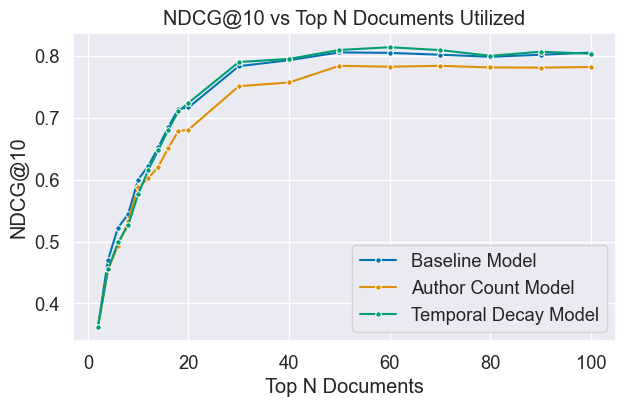

In [26]:
fig, ax = plt.subplots(figsize=(7, 4))
data = results_avg.loc["NDCG@10"][rows[0]:rows[-1]+1]
sns.lineplot(x=[int(i.split(":")[1]) for i in data.index], y=data.values, label="Baseline Model", marker="o", markersize=4)
data_auth = results_avg_auth.loc["NDCG@10"][rows[0]:rows[-1]+1]
sns.lineplot(x=[int(i.split(":")[1]) for i in data_auth.index], y=data_auth.values, label="Author Count Model", marker="o", markersize=4)
data_date = results_avg_date.loc["NDCG@10"][rows[0]:rows[-1]+1]
ax = sns.lineplot(x=[int(i.split(":")[1]) for i in data_date.index], y=data_date.values, label="Temporal Decay Model", marker="o", markersize=4)
ax.set(title="NDCG@10 vs Top N Documents Utilized", xlabel="Top N Documents", ylabel="NDCG@10")
plt.legend()
plt.show()

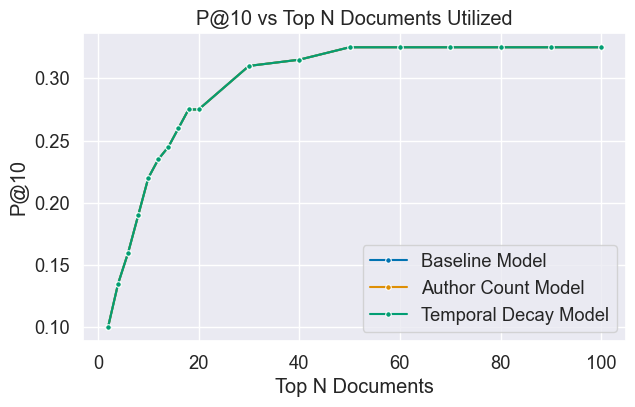

In [27]:
fig, ax = plt.subplots(figsize=(7, 4))
data = results_avg.loc["P@10"][rows[0]:rows[-1]+1]
sns.lineplot(x=[int(i.split(":")[1]) for i in data.index], y=data.values, label="Baseline Model", marker="o", markersize=4)
data_auth = results_avg_auth.loc["P@10"][rows[0]:rows[-1]+1]
sns.lineplot(x=[int(i.split(":")[1]) for i in data_auth.index], y=data_auth.values, label="Author Count Model", marker="o", markersize=4)
data_date = results_avg_date.loc["P@10"][rows[0]:rows[-1]+1]
ax = sns.lineplot(x=[int(i.split(":")[1]) for i in data_date.index], y=data_date.values, label="Temporal Decay Model", marker="o", markersize=4)
ax.set(title="P@10 vs Top N Documents Utilized", xlabel="Top N Documents", ylabel="P@10")
plt.legend()
plt.show()

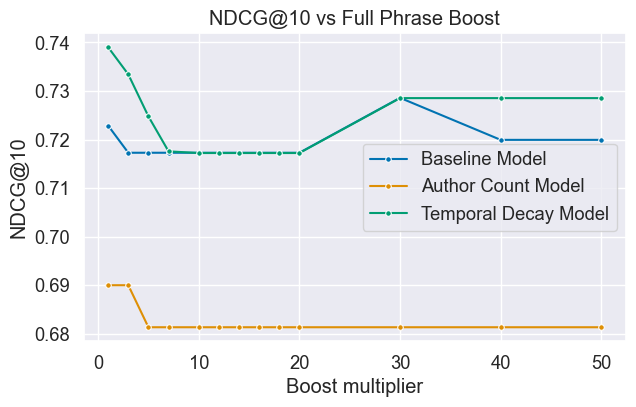

In [28]:
fig, ax = plt.subplots(figsize=(7, 4))
data = results_avg.loc["NDCG@10"][pf[0]:pf[-1]+1]
sns.lineplot(x=[float(i.split(":")[1]) for i in data.index], y=data.values, label="Baseline Model", marker="o", markersize=4)
data_auth = results_avg_auth.loc["NDCG@10"][pf[0]:pf[-1]+1]
sns.lineplot(x=[float(i.split(":")[1]) for i in data_auth.index], y=data_auth.values, label="Author Count Model", marker="o", markersize=4)
data_date = results_avg_date.loc["NDCG@10"][pf[0]:pf[-1]+1]
ax = sns.lineplot(x=[float(i.split(":")[1]) for i in data_date.index], y=data_date.values, label="Temporal Decay Model", marker="o", markersize=4)
ax.set(title="NDCG@10 vs Full Phrase Boost", xlabel="Boost multiplier", ylabel="NDCG@10")
plt.legend()
plt.show()

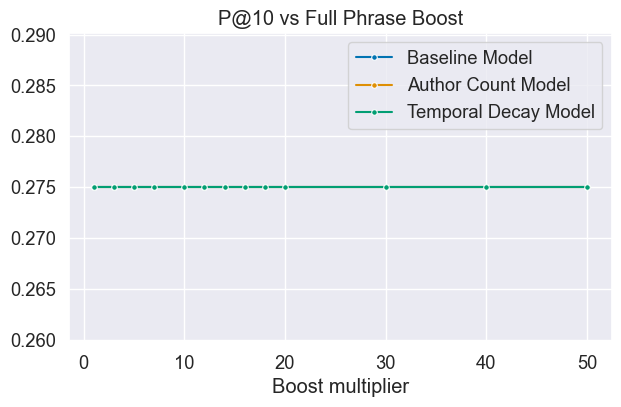

In [29]:
fig, ax = plt.subplots(figsize=(7, 4))
data = results_avg.loc["P@10"][pf[0]:pf[-1]+1]
sns.lineplot(x=[float(i.split(":")[1]) for i in data.index], y=data.values, label="Baseline Model", marker="o", markersize=4)
data_auth = results_avg_auth.loc["P@10"][pf[0]:pf[-1]+1]
sns.lineplot(x=[float(i.split(":")[1]) for i in data_auth.index], y=data_auth.values, label="Author Count Model", marker="o", markersize=4)
data_date = results_avg_date.loc["P@10"][pf[0]:pf[-1]+1]
ax = sns.lineplot(x=[float(i.split(":")[1]) for i in data_date.index], y=data_date.values, label="Temporal Decay Model", marker="o", markersize=4)
ax.set(title="P@10 vs Full Phrase Boost", xlabel="Boost multiplier")
plt.legend()
plt.show()

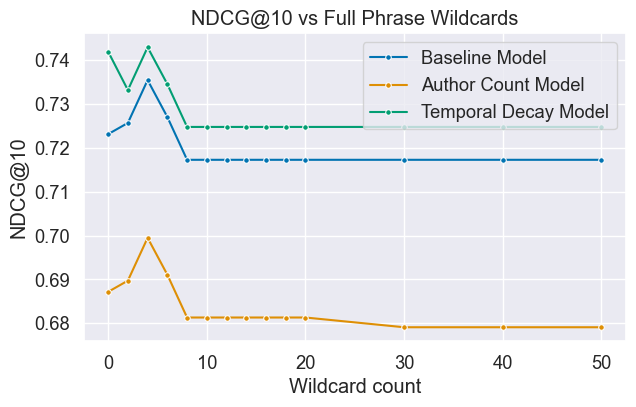

In [30]:
fig, ax = plt.subplots(figsize=(7, 4))
data = results_avg.loc["NDCG@10"][ps[0]:ps[-1]+1]
sns.lineplot(x=[int(i.split(":")[1]) for i in data.index], y=data.values, label="Baseline Model", marker="o", markersize=4)
data_auth = results_avg_auth.loc["NDCG@10"][ps[0]:ps[-1]+1]
sns.lineplot(x=[int(i.split(":")[1]) for i in data_auth.index], y=data_auth.values, label="Author Count Model", marker="o", markersize=4)
data_date = results_avg_date.loc["NDCG@10"][ps[0]:ps[-1]+1]
ax = sns.lineplot(x=[int(i.split(":")[1]) for i in data_date.index], y=data_date.values, label="Temporal Decay Model", marker="o", markersize=4)
ax.set(title="NDCG@10 vs Full Phrase Wildcards", xlabel="Wildcard count", ylabel="NDCG@10")
plt.legend()
plt.show()

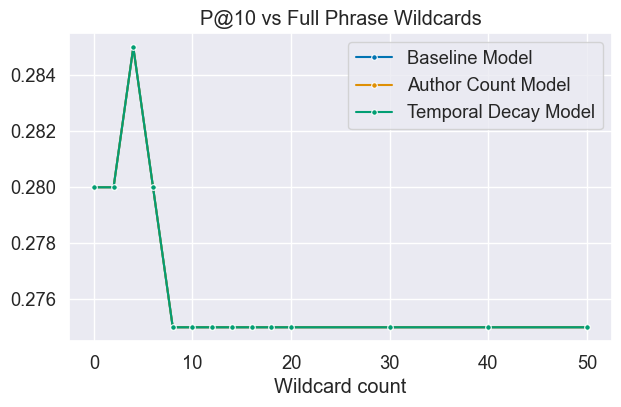

In [31]:
fig, ax = plt.subplots(figsize=(7, 4))
data = results_avg.loc["P@10"][ps[0]:ps[-1]+1]
sns.lineplot(x=[int(i.split(":")[1]) for i in data.index], y=data.values, label="Baseline Model", marker="o", markersize=4)
data_auth = results_avg_auth.loc["P@10"][ps[0]:ps[-1]+1]
sns.lineplot(x=[int(i.split(":")[1]) for i in data_auth.index], y=data_auth.values, label="Author Count Model", marker="o", markersize=4)
data_date = results_avg_date.loc["P@10"][ps[0]:ps[-1]+1]
ax = sns.lineplot(x=[int(i.split(":")[1]) for i in data_date.index], y=data_date.values, label="Temporal Decay Model", marker="o", markersize=4)
ax.set(title="P@10 vs Full Phrase Wildcards", xlabel="Wildcard count")
plt.legend()
plt.show()

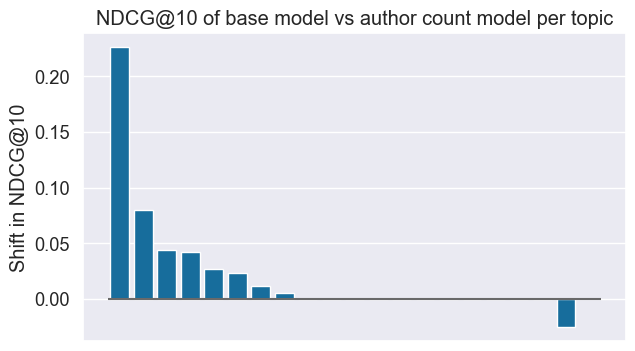

['simulation', 'brain decoding', 'augmented reality', 'virtual reality', 'object detection', 'classification', 'data models', 'anomaly detection', 'populations', 'pandemic prediction', 'optimization', 'operations research', 'speech recognition', 'mobility analytics', 'machine learning', 'convolutional neural networks', 'computer vision', 'semantics', 'species identification', 'reliability']


In [32]:
fig, ax = plt.subplots(figsize=(7, 4))
temp = [results[topic].loc["NDCG@10"]["rows:50"] for topic in topic_list]
temp2 = [results_auth[topic].loc["NDCG@10"]["rows:50"] for topic in topic_list]
temp = [a-b for a, b in zip(temp, temp2)]
ax = sns.barplot(x=topic_list, y=temp, order=[topic_list[i] for i in np.argsort(temp)][::-1])
ax.hlines(y=0, xmin=-0.5, xmax=20.5, color='dimgrey')
ax.set(title="NDCG@10 of base model vs author count model per topic", xticklabels=[], ylabel="Shift in NDCG@10")
plt.show()
print([topic_list[i] for i in np.argsort(temp)][::-1])

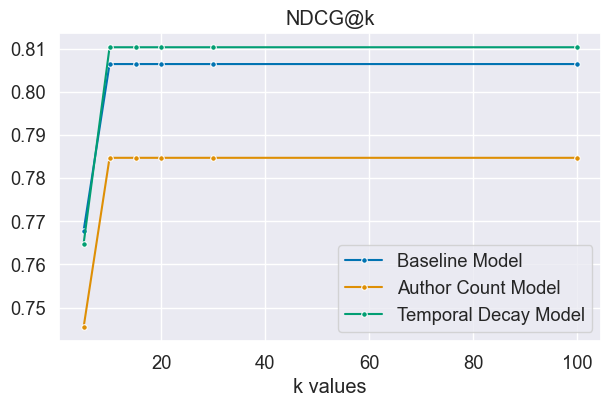

In [33]:
fig, ax = plt.subplots(figsize=(7, 4))
data = results_avg["rows:50"][18:-3]
sns.lineplot(x=[int(i.split("@")[1]) for i in data.index], y=data.values, label="Baseline Model", marker="o", markersize=4)
data_auth = results_avg_auth["rows:50"][18:-3]
sns.lineplot(x=[int(i.split("@")[1]) for i in data_auth.index], y=data_auth.values, label="Author Count Model", marker="o", markersize=4)
data_date = results_avg_date["rows:50"][18:-3]
ax = sns.lineplot(x=[int(i.split("@")[1]) for i in data_date.index], y=data_date.values, label="Temporal Decay Model", marker="o", markersize=4)
ax.set(title="NDCG@k", xlabel="k values")
plt.legend()
plt.show()

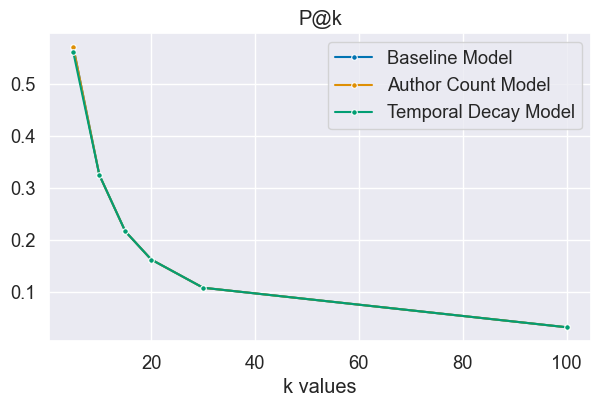

In [34]:
fig, ax = plt.subplots(figsize=(7, 4))
data = results_avg["rows:50"][9:15]
sns.lineplot(x=[int(i.split("@")[1]) for i in data.index], y=data.values, label="Baseline Model", marker="o", markersize=4)
data_auth = results_avg_auth["rows:50"][9:15]
sns.lineplot(x=[int(i.split("@")[1]) for i in data_auth.index], y=data_auth.values, label="Author Count Model", marker="o", markersize=4)
data_date = results_avg_date["rows:50"][9:15]
ax = sns.lineplot(x=[int(i.split("@")[1]) for i in data_date.index], y=data_date.values, label="Temporal Decay Model", marker="o", markersize=4)
ax.set(title="P@k", xlabel="k values")
plt.legend()
plt.show()

In [35]:
collabs = ["CX", "XR", "FG", "LO", "SD", "SL", "NG"]

In [36]:
results

{'anomaly detection':                pf:1.0    pf:3.0    pf:5.0    pf:7.0   pf:10.0   pf:12.0  \
 num_ret             7         7         7         7         7         7   
 num_rel             6         6         6         6         6         6   
 num_rel_ret         5         5         5         5         5         5   
 num_q               1         1         1         1         1         1   
 map             0.675  0.591667  0.591667  0.591667  0.591667  0.591667   
 gm_map          0.675  0.591667  0.591667  0.591667  0.591667  0.591667   
 bpref             0.7  0.666667  0.666667  0.666667  0.666667  0.666667   
 Rprec        0.833333  0.833333  0.833333  0.833333  0.833333  0.833333   
 recip_rank        1.0       0.5       0.5       0.5       0.5       0.5   
 P@5               0.8       0.8       0.8       0.8       0.8       0.8   
 P@10              0.5       0.5       0.5       0.5       0.5       0.5   
 P@15         0.333333  0.333333  0.333333  0.333333  0.333333  0.3

In [37]:
temp = defaultdict(list)
for topic, collab in collab_topic.items():
    temp[collab].append(topic)
for i in temp.items():
    print(i)
    print("NDCG@10:", [round(results_auth[topic].loc["NDCG@10"]["rows:50"], 3) for topic in i[1]])
    print("P@10:", [round(results_auth[topic].loc["P@10"]["rows:50"], 3) for topic in i[1]])
    print("---")

('CX', ['reliability', 'pandemic prediction'])
NDCG@10: [1.0, 0.951]
P@10: [0.5, 0.5]
---
('XR', ['simulation', 'virtual reality', 'augmented reality'])
NDCG@10: [0.693, 0.264, 0.387]
P@10: [0.2, 0.1, 0.1]
---
('FG', ['classification', 'object detection', 'species identification'])
NDCG@10: [0.951, 0.956, 1.0]
P@10: [0.5, 0.4, 0.2]
---
('LO', ['machine learning', 'optimization', 'operations research'])
NDCG@10: [1.0, 0.905, 0.693]
P@10: [0.4, 0.4, 0.2]
---
('SD', ['anomaly detection', 'computer vision', 'brain decoding'])
NDCG@10: [0.905, 0.818, 0.92]
P@10: [0.6, 0.3, 0.2]
---
('SL', ['convolutional neural networks', 'semantics', 'speech recognition'])
NDCG@10: [1.0, 0.0, 0.5]
P@10: [0.3, 0.0, 0.1]
---
('NG', ['data models', 'populations', 'mobility analytics'])
NDCG@10: [0.971, 1.0, 0.782]
P@10: [0.4, 0.6, 0.5]
---


In [38]:
c_results = defaultdict(list)
for topic, vals in results_auth.items():
    c_results[collab_topic[topic]].append(vals)

c_results_avg = dict()
for collab, vals in c_results.items():
    c_results_avg[collab] = sum(vals)/len(vals)

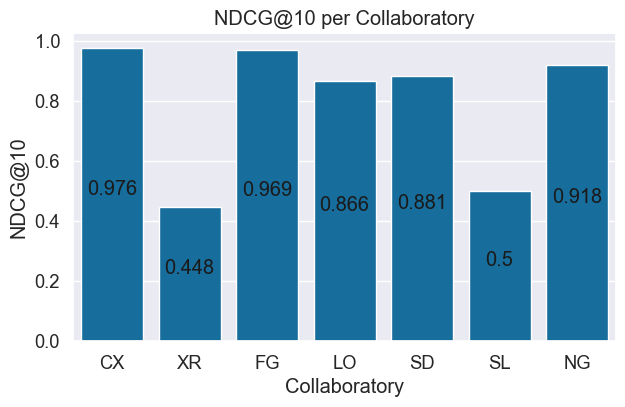

In [39]:
fig, ax = plt.subplots(figsize=(7, 4))
ax = sns.barplot(x=collabs, y=[c_results_avg[c].loc["NDCG@10"]["rows:50"] for c in collabs])
for i, v in enumerate([c_results_avg[c].loc["NDCG@10"]["rows:50"] for c in collabs]):
    ax.text(i, v/2, str(round(v, 3)), ha='center', color='0.1')
ax.set(title="NDCG@10 per Collaboratory", xlabel="Collaboratory", ylabel="NDCG@10")
plt.show()

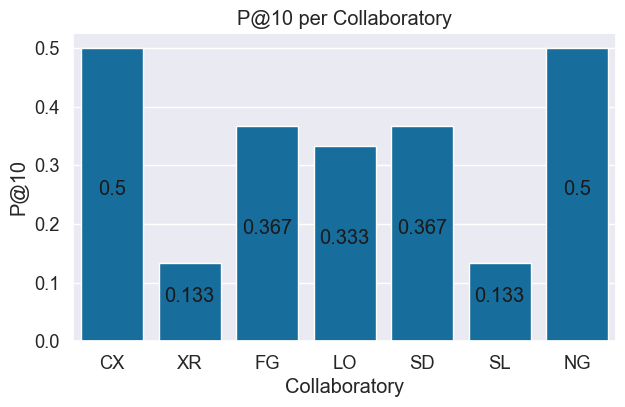

In [40]:
fig, ax = plt.subplots(figsize=(7, 4))
ax = sns.barplot(x=collabs, y=[c_results_avg[c].loc["P@10"]["rows:50"] for c in collabs])
for i, v in enumerate([c_results_avg[c].loc["P@10"]["rows:50"] for c in collabs]):
    ax.text(i, v/2, str(round(v, 3)), ha='center', color='0.1')
ax.set(title="P@10 per Collaboratory", xlabel="Collaboratory", ylabel="P@10")
plt.show()

In [41]:
c_results = defaultdict(set)
for topic, scores in results_iter.items():
    c_results[collab_topic[topic]].update(list(scores["rows:50"].keys())[:10])

In [42]:
c_hit = defaultdict(list)
for collab, affs in c_results.items():
    for aff in affs:
        c = p1_fields.iloc[aff]["Primary"]
        c2 = p1_fields.iloc[aff]["Secondary"]
        if isinstance(c, str):
            if collab == c[-3:-1]:
                c_hit[collab].append(1)
            elif isinstance(c2, str):
                if collab == c2[-3:-1]:
                    c_hit[collab].append(1)
                else:
                    c_hit[collab].append(0)
            else:
                c_hit[collab].append(0)

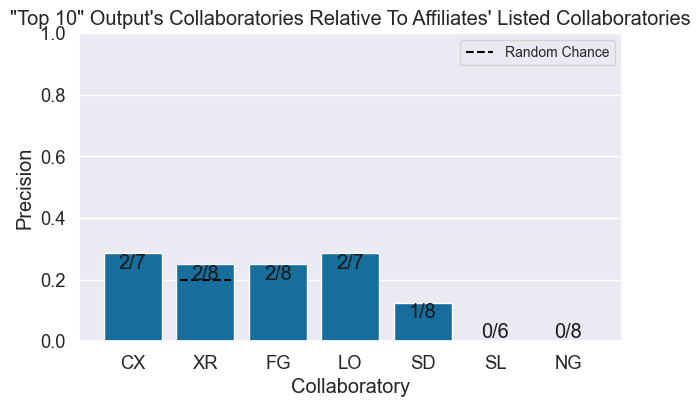

In [43]:
fig, ax = plt.subplots(figsize=(7, 4))
ax = sns.barplot(x=collabs, y=[sum(c_hit[c])/len(c_hit[c]) for c in collabs])
for i, v in enumerate([[sum(c_hit[c]), len(c_hit[c])] for c in collabs]):
    if v[0] != 0:
        temp = (v[0]/v[1])-0.05
    else:
        temp = 0.01
    ax.text(i, temp, str(v[0])+"/"+str(v[1]), ha='center', color='0.1')
ax.set(title="\"Top 10\" Output's Collaboratories Relative To Affiliates' Listed Collaboratories", xlabel="Collaboratory", ylabel="Precision")
ax.set_ylim([0,1])

fields = {k[-3:-1]: v for k, v in ((p1_fields["Primary"].value_counts() + p1_fields["Secondary"].value_counts()) / p1_fields.shape[0]).items()}
for i, c in enumerate(collabs):
    if c in fields:
        ax.hlines(y=fields[c], xmin=i-0.35, xmax=i+0.35, color='black', linestyles="dashed")
line = Line2D([0], [0], color='black', linestyle="dashed")
ax.legend(handles=[line], labels=["Random Chance"], fontsize=10)

plt.show()

In [44]:
{k[-3:-1]: v for k, v in ((p1_fields["Primary"].value_counts() + p1_fields["Secondary"].value_counts()) / p1_fields.shape[0]).items()}

{'CX': nan, 'XR': 0.2, 'FG': nan, 'LO': nan, 'SD': nan}

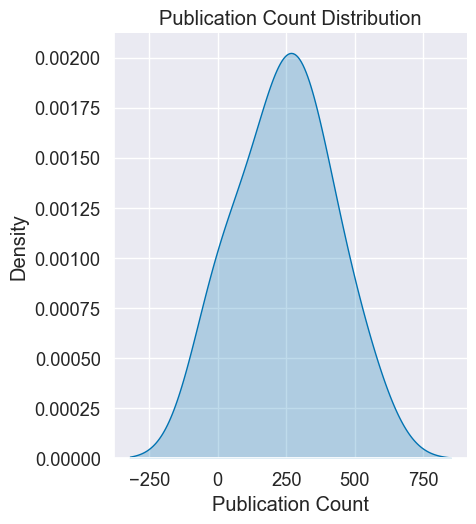

In [45]:
data = [len(links) for links in p1_p["pdf_links"]]
sns.displot(data, kind="kde", bw_adjust=1, fill=True).set(title="Publication Count Distribution", xlabel="Publication Count")
#sns.displot(data, kde=True, bins=25).set(title="Publication Count Distribution", xlabel="Number Publications", ylabel="Number Affiliates")
plt.show()

In [46]:
print("Publications Stats")
print("total:", len(doc_key.keys()))
print("mean per affiliate:", round(np.mean(data), 1))
print("median per affiliate:", np.median(data))
print("min per affiliate:", min(data))
print("max per affiliate:", max(data))
print("affiliates with zero:", str(data.count(0))+"/"+str(len(data)))
print("affiliates with one:", str(data.count(1))+"/"+str(len(data)))
print("affiliates with two:", str(data.count(2))+"/"+str(len(data)))
print("affiliates with three:", str(data.count(3))+"/"+str(len(data)))

Publications Stats
total: 1227
mean per affiliate: 243.6
median per affiliate: 261.0
min per affiliate: 0
max per affiliate: 530
affiliates with zero: 1/10
affiliates with one: 0/10
affiliates with two: 1/10
affiliates with three: 0/10


In [47]:
print("affiliates with Orcid:", str(list(p1_info["Orcid"].isna()).count(0))+"/"+str(p1_info.shape[0]))
print("mean name variations of those who had at least one found:", round(np.mean([len(names) for names in p1_p["name_vars"] if len(names)>0]), 1))
print("median name variations of those who had at least one found:", np.median([len(names) for names in p1_p["name_vars"] if len(names)>0]))
print("affiliates who did not use their orcid at all:", str([len(names) for names in p1_p["name_vars"]].count(0))+"/"+str(p1_p.shape[0]))
print("affiliates who had Orcid yet were unable to make use of it:", [len(names) for names in p1_p["name_vars"]].count(0) - (p1_info.shape[0] - list(p1_info["Orcid"].isna()).count(0)))

affiliates with Orcid: 2/10
mean name variations of those who had at least one found: 1.0
median name variations of those who had at least one found: 1.0
affiliates who did not use their orcid at all: 8/10
affiliates who had Orcid yet were unable to make use of it: 0


In [48]:
temp = {"total":0, "loc":0, "rem":0, "doi":0}
for i, file_name in enumerate(p1_p["jsons"]):
    #Checks that file exists before opening
    if os.path.exists("Affiliate_jsons/" + file_name):
        #Opens file
        with open("Affiliate_jsons/" + file_name) as file:
            #Loads file
            publications = json.load(file)
        temp["total"] += len(publications) #ignores oa_link check
        for p in publications:
            if "oa_link" in p:
                for link in sorted(p["oa_link"], key=lambda link:{"loc":0, "rem":1, "doi":2}[link["type"]]):
                    if "url" in link:
                        if link["type"] == "loc":
                            temp["loc"] += 1
                            break
                        elif link["type"] == "rem":
                            temp["rem"] += 1
                            break
                        elif link["type"] == "doi":
                            temp["doi"] += 1
print(temp) #a lot of rem/doi links just return htmls, not pdfs.
print("loc/total:", round(temp["loc"]/(temp["loc"]+temp["rem"]+temp["doi"]), 2))
print("used/total:", round(len(doc_key)/(temp["loc"]+temp["rem"]+temp["doi"]), 2))
print("used/loc:", round(len(doc_key)/(temp["loc"]), 2))

{'total': 17236, 'loc': 4679, 'rem': 2374, 'doi': 3462}
loc/total: 0.44
used/total: 0.12
used/loc: 0.26
